In [148]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import itertools 
from tqdm import tqdm 
import warnings 
import subprocess
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile, fasta_get_genome_size
from src.metat import * 
import json
from Bio import Align
from Bio.Seq import Seq
import itertools
import scipy
import sklearn
import requests
import itertools
from src.kegg import *
from scipy.stats import pearsonr
import networkx as nx
import statsmodels.stats.multitest as smm

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:

read_length = 150

# def filter_low_counts(metat_df, min_count:int=3, min_samples:int=4):
#     mask = metat_df.groupby('id').apply(lambda df : np.sum(df.groupby('sample_name').read_count.sum() >= min_count) >= min_samples, include_groups=False)
#     keep_ids = metat_df.groupby('id').first().index
#     keep_ids = keep_ids[mask].values
#     print(f'filter_low_counts: Keeping {len(keep_ids)} out of {metat_df['id'].nunique()} total genes.')
#     metat_df = metat_df[metat_df['id'].isin(keep_ids)].copy()
#     return metat_df

# Use CPM-based filtering to control for library size. 

def filter_low_counts(metat_df, min_cpm:float=1, min_samples:int=6, scale_min_cpm:bool=True):

    metat_df = metat_df.drop(columns=['cpm_scale_factor'], errors='ignore').copy()

    if scale_min_cpm:
        cpm_scale_df = metat_df.groupby(['sample_name', 'target_name']).agg({'read_count_original':'sum', 'library_size':'first'}).reset_index()
        cpm_scale_df['cpm_scale_factor'] = cpm_scale_df.read_count_original / cpm_scale_df.library_size
        metat_df = metat_df.merge(cpm_scale_df.drop(columns=['read_count_original', 'library_size']), on=['sample_name', 'target_name'])
        metat_df['min_cpm'] = min_cpm * metat_df.cpm_scale_factor
    else:
        metat_df['min_cpm'] = min_cpm

    metat_df['cpm'] = metat_df.read_count_original / (metat_df.library_size / 1e6)
    # There should only be one entry per gene per ID per sample. 
    # assert np.all(metat_df['id'].value_counts() == metat_df.sample_name.nunique()), 'filter_low_counts: There should be one count entry per gene per sample.'

    mask = metat_df.groupby('id').apply(lambda df : np.sum(df.cpm >= df.min_cpm) >= min_samples, include_groups=False)
    keep_ids = mask.index[mask.values]

    print(f'filter_low_counts: Keeping {len(keep_ids)} out of {metat_df['id'].nunique()} total genes.')
    metat_df = metat_df[metat_df['id'].isin(keep_ids)].copy()

    return metat_df

def label_samples(figure_df, sample_names:list=[], ax=None, x_column='rpkm', y_column='coverm_rpkm', alignment:str='left'):
    for row in figure_df[figure_df.sample_name.isin(sample_names)].itertuples():
        x, y = getattr(row, x_column), getattr(row, y_column)
        ax.text(x, y, row.sample_name, fontsize='x-small', fontweight='bold', ha=alignment)


In [150]:
metat_summary_df = metat_load_summary() 

coverm_df = coverm_load() # Load the metagenome read mapping stuff.
coverm_df = coverm_df[['trimmed_mean', 'rpkm', 'sample_name', 'target_name']].copy().rename(columns={'rpkm':'coverm_rpkm', 'mean':'coverm_coverage'})
coverm_df = coverm_df[coverm_df.sample_name.isin(metat_summary_df.sample_name.unique())].copy()

# RPKM is number of reads per thousand base pairs per million reads (so normalized by genome size and library size).
metat_summary_df = metat_add_library_size(metat_summary_df)
metat_summary_df['genome_size'] = metat_summary_df.target_name.map(genome_sizes)
metat_summary_df['rpkm'] = metat_summary_df.n_assigned / (metat_summary_df.genome_size / 1e3) / (metat_summary_df.library_size / 1e6)
metat_summary_df['coverage'] = metat_summary_df['n_assigned'] * read_length / metat_summary_df.genome_size 
metat_summary_df = metat_summary_df.merge(coverm_df, on=['sample_name', 'target_name'])
metat_summary_df['normalized_rpkm'] = np.log(metat_summary_df.rpkm / metat_summary_df.coverm_rpkm)
# metat_summary_df['normalized_rpkm'] = metat_summary_df.rpkm / metat_summary_df.coverm_rpkm

figure: Slope of fitted line: 1.0252655974434564


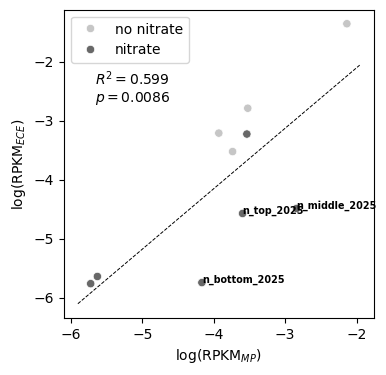

In [151]:
def figure(metat_summary_df:pd.DataFrame, exclude_samples=[], log_scale:bool=True):

    figure_df = metat_summary_df.copy()
    figure_df = figure_df[~figure_df.sample_name.isin(exclude_samples)].copy()

    figure_df = figure_df[figure_df.target_name.isin([ece_id, 'methanoperedens_2'])].copy()
    # figure_df = figure_df.pivot(columns='target_name', values='coverage', index='sample_name')
    figure_df = figure_df.pivot(columns='target_name', values='rpkm', index='sample_name')
    if log_scale:
        figure_df = np.log(figure_df) # Log-normalize the coverage values. 
    figure_df = figure_df.reset_index(names='sample_name')
    figure_df['category'] = np.where(figure_df.sample_name.str.startswith('n_'), 'nitrate', 'no nitrate')

    fig, ax = plt.subplots(figsize=(4, 4), ncols=1)
    sns.scatterplot(figure_df, x=mp_id, y=ece_id, ax=ax, hue='category', palette='Grays')
    ax.legend().set_title('')

    y, x = figure_df[ece_id].values, figure_df[mp_id].values 
    result = pearsonr(x, y, alternative='two-sided')
    m, b = np.polyfit(x, y, 1)
    print('figure: Slope of fitted line:', m)

    r = result.statistic
    p = result.pvalue 

    x_min, x_max = ax.get_xlim()
    sns.lineplot(x=np.linspace(x_min, x_max, 10), y=np.linspace(x_min, x_max, 10) * m + b, ls='--', color='black', lw=0.7)
    ax.text(0.1, 0.7, f'$R^2=$' + f'{r ** 2:.3f}\n' + f'$p={p:.4f}$', transform=ax.transAxes)

    ax.set_xlabel('log(RPKM$_{MP}$)' if log_scale else 'RPKM$_{MP}$')
    ax.set_ylabel('log(RPKM$_{ECE}$)' if log_scale else 'RPKM$_{ECE}$')
    sns.move_legend(ax, loc='upper left')
    
    sample_names = ['n_bottom_2025', 'n_middle_2025', 'n_top_2025']
    label_samples(figure_df, sample_names=sample_names, ax=ax, y_column=ece_id, x_column='methanoperedens_2', alignment='left')

    plt.show()

    return figure_df

# figure_df = figure(metat_summary_df, exclude_samples=['n_top_2025', 'n_bottom_2025', 'n_middle_2025'])
figure_df = figure(metat_summary_df, exclude_samples=[], log_scale=True)

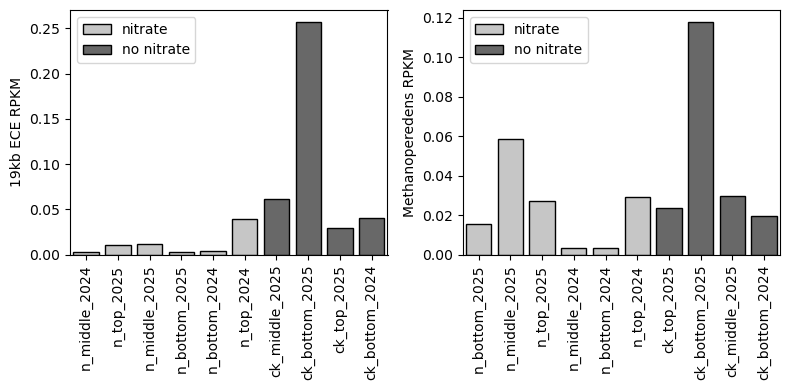

In [152]:
def figure(metat_summary_df:pd.DataFrame, target_name:str=ece_id, metric='rpkm', ax=None):
    target_name_map = {ece_id:'19kb ECE', 'methanoperedens_2':'Methanoperedens', 'methanoperedens_1':'Methanoperedens'}

    figure_df = metat_summary_df[metat_summary_df.target_name == target_name].copy()
    figure_df['category'] = np.where(figure_df.sample_name.str.startswith('n_'), 'nitrate', 'no nitrate')

    sns.barplot(figure_df.sort_values('category'), x='sample_name', y=metric, ax=ax, hue='category', palette='Grays', edgecolor='black')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel(target_name_map[target_name] + ' RPKM')
    ax.legend().set_title('')

fig, (ax_a, ax_b) = plt.subplots(figsize=(8, 4), ncols=2)

figure(metat_summary_df, target_name='ece_26_1334', ax=ax_a)
figure(metat_summary_df, target_name='methanoperedens_2', ax=ax_b)
fig.tight_layout()
plt.show()
# figure(metat_summary_df, target_name='methanoperedens_2')

# Relative decrease in transcriptional activity seems less severe for Methanoperedens overall in no nitrate versus nitrate, 
# i.e. transcriptional activity of the ECE declines more without nitrate than the transcriptional activity of 
# Methanoperedens.

# Want to find a way to show that the decrease in the transcriptional activity of the ECE is more severe than that of the 
# host, which means we need (1) a measure of transcriptional activity for each sample, normalized by the amount of DNA in the sample, 

In [256]:
print(coverm_df[coverm_df.target_name == ece_id].to_csv())

,trimmed_mean,coverm_rpkm,sample_name,target_name
18,542.9334,11.089685676728951,ck_bottom_2024,ece_26_1334
20,208.71721,5.116657894826892,ck_bottom_2025,ece_26_1334
22,337.54572,9.392221468313775,ck_middle_2025,ece_26_1334
24,284.58298,6.957762867518201,ck_top_2025,ece_26_1334
26,108.8332,3.8172173745507685,n_bottom_2024,ece_26_1334
28,9.493707,0.20844917736605134,n_bottom_2025,ece_26_1334
30,192.45465,4.508889420704666,n_middle_2024,ece_26_1334
32,35.444065,0.7193639212048877,n_middle_2025,ece_26_1334
34,332.80368,7.494646780829509,n_top_2024,ece_26_1334
36,77.97859,2.0953005322403477,n_top_2025,ece_26_1334



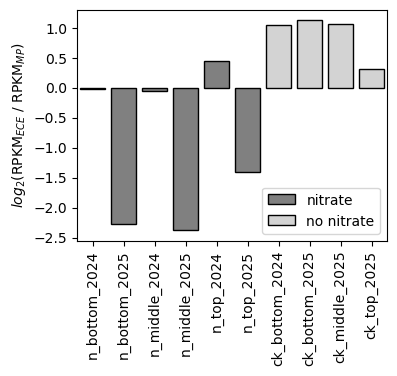

In [153]:
def figure(metat_summary_df:pd.DataFrame):
    # Looking at ratios of log, and both are negative, so a higher ratio means that the ECE expression is more negative than the 
    # host, i.e. smaller. So it is a bit misleading to just plot the ratio. 
    fig, ax = plt.subplots(figsize=(4, 3))

    figure_df = metat_summary_df.copy()
    figure_df = figure_df.pivot(index='sample_name', columns='target_name', values='rpkm')
    figure_df = figure_df.reset_index()
    # figure_df['log_ratio'] = np.log(figure_df[ece_id]) / np.log(figure_df['methanoperedens_2'])
    figure_df['log_ratio'] = np.log2(figure_df[ece_id] / figure_df['methanoperedens_2'])
    figure_df['category'] = np.where(figure_df.sample_name.str.startswith('n_'), 'nitrate', 'no nitrate')
    palette = {'nitrate':'gray', 'no nitrate':'lightgray'}
    sns.barplot(figure_df.sort_values('category'), x='sample_name', y='log_ratio', ax=ax, hue='category', palette=palette, edgecolor='black')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    # ax.set_ylabel('log(RPKM$_{ECE}$) / log(RPKM$_{MP}$)')
    ax.set_ylabel('$log_2$(RPKM$_{ECE}$ / RPKM$_{MP}$)')
    ax.legend().set_title('')
    sns.move_legend(ax, 'lower right')
    plt.show()

figure(metat_summary_df)

figure: Slope of fitted line: 0.659687178993269
figure: Slope of fitted line: 1.0083896446776468


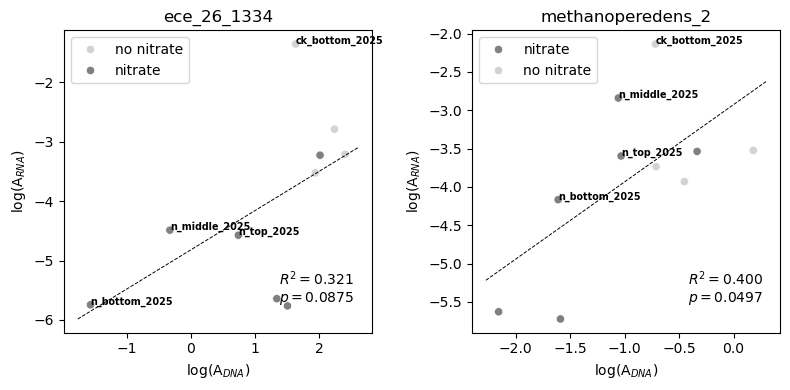

In [154]:
# Based on the results above, it does seem like there may be some effect whereby the transcriptional activity decreases more 
# than the actual amount of ECE DNA in the sample. Perhaps this means that there is an extracellular phase that makes up the difference, 
# or perhaps ECE genes are just generally down-regulated in high nitrate? 
# 
# Question: Can the decrease in transcription from the ECE be explained purely by the decrease in the absolute amount of the ECE?  
# Want to somehow normalize by the metagenome read counts. 
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

for ax, target_name in zip(axes, ['ece_26_1334', 'methanoperedens_2']):
    figure_df = metat_summary_df[metat_summary_df.target_name == target_name].copy()
    # figure_df = figure_df[~figure_df.sample_name.str.match('n_.*_2025')].copy()
    figure_df['rpkm'] = np.log(figure_df.rpkm)
    figure_df['coverm_rpkm'] = np.log(figure_df.coverm_rpkm)
    figure_df['category'] = np.where(figure_df.sample_name.str.startswith('n_'), 'nitrate', 'no nitrate')

    palette = {'nitrate':'gray', 'no nitrate':'lightgray'}
    ax = sns.scatterplot(figure_df, x='coverm_rpkm', y='rpkm', ax=ax, hue='category', palette=palette)

    y, x = figure_df['rpkm'].values, figure_df['coverm_rpkm'].values 
    result = pearsonr(x, y, alternative='two-sided')
    m, b = np.polyfit(x, y, 1)
    print('figure: Slope of fitted line:', m)

    r = result.statistic
    p = result.pvalue 

    x_min, x_max = ax.get_xlim()
    sns.lineplot(x=np.linspace(x_min, x_max, 10), y=np.linspace(x_min, x_max, 10) * m + b, ls='--', color='black', lw=0.7, ax=ax)
    ax.text(0.7, 0.1, f'$R^2=$' + f'{r ** 2:.3f}\n' + f'$p={p:.4f}$', transform=ax.transAxes)
    ax.set_title(target_name)
    ax.set_xlabel('log(A$_{DNA}$)')
    ax.set_ylabel('log(A$_{RNA}$)')
    
    sample_names = ['n_bottom_2025', 'n_middle_2025', 'n_top_2025', 'ck_bottom_2025']
    label_samples(figure_df, sample_names=sample_names, ax=ax, y_column='rpkm', x_column='coverm_rpkm')

    # ax.get_legend().set_title('')
fig.tight_layout()
plt.show()

# There should be a log-linear relationship between RNA and DNA coverage. 

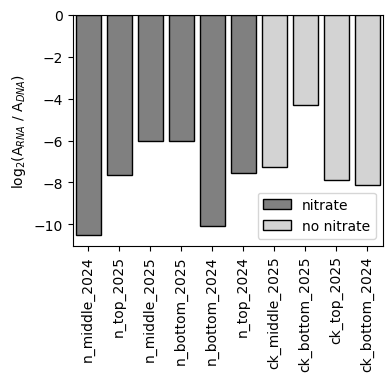

In [155]:
def figure(metat_summary_df:pd.DataFrame):
    # Looking at ratios of log, and both are negative, so a higher ratio means that the ECE expression is more negative than the 
    # host, i.e. smaller. So it is a bit misleading to just plot the ratio. 
    fig, ax = plt.subplots(figsize=(4, 3))

    figure_df = metat_summary_df[metat_summary_df.target_name == ece_id].copy()
    figure_df['log_ratio'] = np.log2(figure_df['rpkm'] / figure_df['coverm_rpkm'])
    figure_df['category'] = np.where(figure_df.sample_name.str.startswith('n_'), 'nitrate', 'no nitrate')
    palette = {'nitrate':'gray', 'no nitrate':'lightgray'}
    
    sns.barplot(figure_df.sort_values('category'), x='sample_name', y='log_ratio', ax=ax, hue='category', palette=palette, edgecolor='black')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('log$_2$(A$_{RNA}$ / A$_{DNA}$)')
    ax.legend().set_title('')
    sns.move_legend(ax, 'lower right')
    plt.show()

figure(metat_summary_df)
# The larger log-fold decrease in the 2024 nitrate-rich samples seems to be related to the fact that ECE DNA concentrations remain high, so maybe
# refflect an increase in the amount of ECE in an extracellular phase. 

In [156]:
metat_df = metat_load()
metat_df = metat_df[~metat_df.target_name.isin(['ece_26_1334_all_orfs', 'ece_26_1334_rev'])].copy()
metat_df['id'] = [f'{row.target_name}.{row.gene_id}' for row in metat_df.itertuples()] # Make sure the gene ID is unique for each target. 
metat_df = metat_add_library_size(metat_df)
metat_df = filter_low_counts(metat_df)
metat_df['rpkm_with_pseudocount'] = metat_df.read_count / (metat_df.length / 1e3) / (metat_df.library_size / 1e6)
metat_df['rpkm_without_pseudocount'] = metat_df.read_count_original / (metat_df.length / 1e3) / (metat_df.library_size / 1e6)

filter_low_counts: Keeping 1288 out of 5049 total genes.


In [157]:
def clr_normalize(metat_df):
    # I think I want to normalize by genome and by sample in order to figure out differential regulation... 
    # assert metat_df.target_name.nunique() == 1, 'get_clr_normalization: Expected only one target genome in the DataFrame.'
    clr_mean = {sample_name:np.log(scipy.stats.gmean(df.rpkm_with_pseudocount)) for sample_name, df in metat_df.groupby('sample_name')}
    metat_df['rpkm_clr_mean'] = metat_df.sample_name.map(clr_mean)
    # Should not ba adding zero here, because it distorts the ratios. Instead, use multiplicative zero replacement, which keeps ratios of the nonzero elements the same.
    metat_df['rpkm_clr_normalized'] = np.log(metat_df.rpkm_with_pseudocount) - metat_df.rpkm_clr_mean
    return metat_df

# I suspect that most, if not all, of the zeros are sampling zeros due to insufficient read depth, and reflect a lack of genome abundance rather
# than changes in gene expression. I think it's a good idea to remove the high-nitrate samples from consideration. 
ece_metat_df = metat_df[metat_df.target_name == ece_id].copy()
ece_metat_df = ece_metat_df[(~ece_metat_df.sample_name.str.startswith('n_')) | (ece_metat_df.sample_name == 'n_top_2024')].copy()
ece_metat_df = clr_normalize(ece_metat_df)


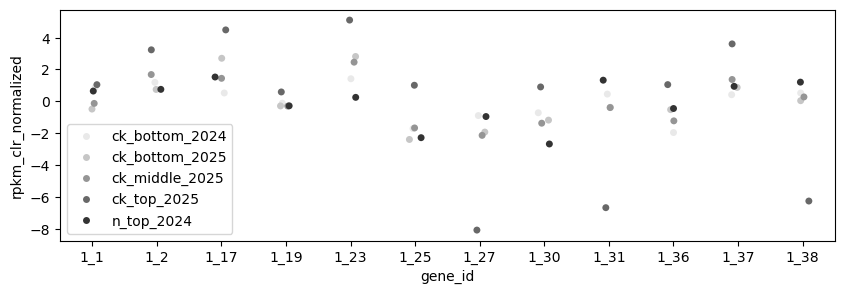

In [158]:

# It seems very possible that MAG abundance would not be a good way to normalize the read count, as I have reason to believe
# a good portion of the DNA in the sample is in a virion phase, and is not transcriptionally-active. 
fig, ax = plt.subplots(figsize=(10, 3))
figure_df = ece_metat_df.copy()
# figure_df['category'] = np.where(figure_df.sample_name.str.startswith('n_'), 'nitrate', 'no nitrate')

figure_df['category'] = np.select([figure_df.sample_name.str.contains('top'), figure_df.sample_name.str.contains('middle'), figure_df.sample_name.str.contains('bottom')], ['top', 'middle', 'bottom'], default='none')
# Because the ECEs are low-abundance in the samples with nitrate, it is hard to tell how much is due to a change in transcription 
# or due to a decrease in abundance. perhaps would be good to normalize by ece abundance as well. 

# sns.stripplot(figure_df, x='gene_id', y='rpkm_clr_normalized', hue='category', palette='Grays')
sns.stripplot(figure_df, x='gene_id', y='rpkm_clr_normalized', hue='sample_name', palette='Grays')
# ax.set_yscale('log')
ax.get_legend().set_title('')
plt.show()


# What could be different about the ck_top_2025 sample? Higher concentrations of some nutrients, perhaps? And perhaps the effect
# does not hold up in n_top_202x due to the stress put on the Methanoperedens by the nitrate. 

In [173]:
# Slightly worried that the weirdness in the n_bottom and n_middle 2024 samples is due to low Methanoperedens abundance, and can't be used
# to assess differential regulation. However, it is worth noting that looking at the read count plots from the metatranscriptome, the n_bottom 
# abundance in 2024 is similar to the n_middle abundance in 2025, which leads me to believe that the zeros might actually be true zeros, i.e. 
# there is genuinely a large change in the set of genes which are regulated. Perhaps the abundance in n_bottom_2024 is a bit low... 

# Worth noting that there are only 22 genes which are detected *at all* in all samples. 

sample_names_2024 = ['n_bottom_2024', 'n_middle_2024', 'n_top_2024']
sample_names_2025 = ['n_bottom_2025', 'n_middle_2025', 'n_top_2025']

metat_df = metat_load()
metat_df = metat_df[~metat_df.target_name.isin(['ece_26_1334_all_orfs', 'ece_26_1334_rev'])].copy()
metat_df['id'] = [f'{row.target_name}.{row.gene_id}' for row in metat_df.itertuples()] # Make sure the gene ID is unique for each target. 
metat_df = metat_add_library_size(metat_df)
metat_df['rpkm_with_pseudocount'] = metat_df.read_count / (metat_df.length / 1e3) / (metat_df.library_size / 1e6)
metat_df['rpkm_without_pseudocount'] = metat_df.read_count_original / (metat_df.length / 1e3) / (metat_df.library_size / 1e6)
metat_df = metat_df[metat_df.sample_name.isin(sample_names_2024 + sample_names_2025)].copy() # Maybe just focus on the nitrate samples?

mp_metat_df = metat_df[metat_df.target_name == mp_id].copy()
# mp_metat_df = mp_metat_df[~mp_metat_df.sample_name.isin(['n_middle_2024', 'n_bottom_2024'])].copy()
mp_metat_df = filter_low_counts(mp_metat_df, min_cpm=1e2, min_samples=3)
mp_metat_df = clr_normalize(mp_metat_df)


# I am also worried that filtering out genes which do not meet the minimum count requirement in four samples could be excluding genes
# with extreme differential expression?

for sample_name, df in mp_metat_df.groupby('sample_name'):
    print(f'Percentage of zero-count genes in sample {sample_name}: { 100 * (df.read_count_original == 0).sum() / len(df):.2f}%')


filter_low_counts: Keeping 727 out of 2733 total genes.
Percentage of zero-count genes in sample n_bottom_2024: 53.65%
Percentage of zero-count genes in sample n_bottom_2025: 31.09%
Percentage of zero-count genes in sample n_middle_2024: 53.37%
Percentage of zero-count genes in sample n_middle_2025: 12.24%
Percentage of zero-count genes in sample n_top_2024: 10.45%
Percentage of zero-count genes in sample n_top_2025: 41.40%


In [174]:
gene_ids_expressed_in_all_samples = ['1_20', '1_49', '2_122', '2_139', '3_105', '3_111', '3_120', '4_55', '4_102', '6_110', '7_102', '8_22', '10_52', '14_69', '15_29', '18_1', '20_47', '22_9', '23_34', '27_6', '28_18', '45_3']
print('Num. genes detected in all samples:', len(gene_ids_expressed_in_all_samples))

ko_df = kegg_load('../data/kegg/methanoperedens_2.txt')
ko_df = ko_df.sort_values('e_value').drop_duplicates('id')
# ko_df[ko_df['id'].isin(gene_ids_expressed_in_all_samples)]

Num. genes detected in all samples: 22


In [175]:
pca_df = mp_metat_df.copy()
pca_df = pca_df.pivot(columns='id', values='rpkm_clr_normalized', index='sample_name')

pca = sklearn.decomposition.PCA(n_components=5) # I think this automatically normalizes. Also might not need to because it's already CLR normalized. 
pca.fit(pca_df.values)

print(f'PCA explained variance: {', '.join(pca.explained_variance_ratio_.astype(str))}')

PCA explained variance: 0.35079202712038743, 0.25085909292255315, 0.19469037428544803, 0.12184954179223027, 0.081808963879381


In [176]:
# ko_to_pathway_map = kegg_get_pathways_by_ko(ko_df.ko.unique())
# ko_to_module_map, module_to_ko_map = kegg_get_modules_by_ko(ko_df.ko.unique())
# module_name_map = {module:kegg_get_module(module) for module in module_to_ko_map.keys()}

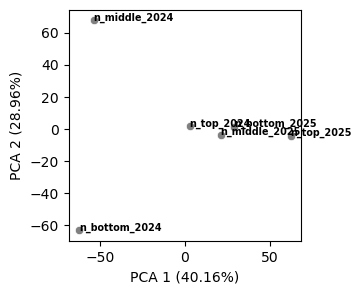

In [172]:
def plot_pca(pca_df:pd.DataFrame, pca:sklearn.decomposition.PCA, components:list=[0, 1]):

    x, y = pca.fit_transform(pca_df.values).T[components, :]

    figure_df = pd.DataFrame(index=pca_df.index)
    figure_df[f'pca_x'], figure_df['pca_y'] = x, y
    figure_df['sample_name'] = figure_df.index
    figure_df['nitrate'] = figure_df.index.str.startswith('n_')
    figure_df['nitrate'] = np.where(figure_df.nitrate, '+', '-')

    get_sample_location = lambda sample_name : re.search('top|bottom|middle', sample_name).group(0)
    figure_df['location'] = figure_df.sample_name.apply(get_sample_location)

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(figure_df, x='pca_x', y='pca_y', color='gray')


    sample_names = ['n_top_2025', 'n_middle_2025', 'n_bottom_2025']
    sample_names += ['n_top_2024', 'n_middle_2024', 'n_bottom_2024']
    label_samples(figure_df, sample_names=sample_names, ax=ax, x_column='pca_x', y_column='pca_y')

    ax.set_xlabel(f'PCA {components[0] + 1} ({pca.explained_variance_ratio_[components[0]] * 100:.2f}%)')
    ax.set_ylabel(f'PCA {components[1] + 1} ({pca.explained_variance_ratio_[components[1]] * 100:.2f}%)')

    plt.show()

plot_pca(pca_df, pca, components=[0, 1])

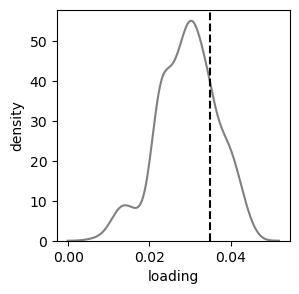

Num. features with importance > 0.035: 159


In [201]:
threshold = 0.035

loadings = pca.components_.T # Components are the eigenvectors, which shape (n_components, n_features). Not sure why we need to take the absolute value?
# To get the feature importance, need the loadings scaled by the explained variance ratio (probably regular explained variance would also work)
loadings = np.abs(loadings) * pca.explained_variance_ratio_.reshape(1, -1) # End up with a 1125 by 5 matrix; this is broadcasting, not matrix multiplication. 
loadings = loadings.sum(axis=1) # Get total importance of each feature. 

n_features = pca_df.shape[-1]
figure_df = pd.DataFrame(index=np.arange(n_features))
figure_df['gene_id'] = pca_df.columns 
figure_df['loading'] = loadings
figure_df['ko'] = figure_df['gene_id'].map(ko_df.set_index('id').ko)
figure_df['ko_name'] = figure_df['gene_id'].map(ko_df.set_index('id').definition)

fig, ax = plt.subplots(figsize=(3, 3))
sns.kdeplot(figure_df, x='loading', color='gray')
ax.set_ylabel('density')
ax.axvline(threshold, ls='--', color='black')
plt.show()
print(f'Num. features with importance > {threshold}:', (figure_df.loading > threshold).sum())

important_gene_ids = figure_df[figure_df.loading > threshold].sort_values('loading')['gene_id'].unique()
important_gene_ids = [gene_id.split('.')[-1] for gene_id in important_gene_ids]




In [202]:
# n_sample_names = metat_df.sample_name[metat_df.sample_name.str.startswith('n_')].unique()
# ck_sample_names = metat_df.sample_name[~metat_df.sample_name.str.startswith('n_')].unique()

sample_names_2024 = ['n_bottom_2024', 'n_middle_2024', 'n_top_2024']
sample_names_2025 = ['n_bottom_2025', 'n_middle_2025', 'n_top_2025']
sample_pairs = list(itertools.product(sample_names_2025, sample_names_2024))

def get_differential_expression(metat_df:pd.DataFrame, sample_pairs:list=sample_pairs):
    '''Limited by the fact that I don't have true technical replicates.'''
    # Each row is a gene and each column is the expression level of that gene in the sample.
    df = metat_df.pivot(columns='sample_name', values='rpkm_clr_normalized', index='gene_id').copy()
    df = df.reset_index()

    diff_df = list()
    for sample_name, control_sample_name in sample_pairs:
        diff_df += [{'gene_id':row['gene_id'], 'delta':row[sample_name] - row[control_sample_name], 'control_sample_name':control_sample_name, 'sample_name':sample_name} for row in df.to_dict(orient='records')]
    diff_df = pd.DataFrame(diff_df)

    has_consistent_regulation = lambda df : np.all(np.sign(df.delta.values) == np.sign(df.delta.values)[0])
    diff_df['consistent'] = diff_df['gene_id'].map(diff_df.groupby('gene_id').apply(has_consistent_regulation, include_groups=False))
    
    return diff_df

mp_diff_df = get_differential_expression(mp_metat_df)
print('Num. genes consistently regulated:', mp_diff_df[mp_diff_df.consistent].gene_id.nunique())


Num. genes consistently regulated: 123


In [ ]:

annotations = dict()

# Downregulated in 2025 relative to 2024. 
annotations['24_8'] = ('eCIS core domain', 'Formerly DUF4157 domain-containing protein. eCIS stands for extracellular Contractile Injection System, and this region is responsible for protein toxicity. eCIS-associated toxins carry DUF4157 domains in their N terminus or are found adjacent to genes with this domain')
annotations['6_49'] = ('DNA methylase', 'This particular protein seems to have high similarity to Vaccinia Virus protein VP39, which acts as VP39 is a bifunctional vaccinia virus protein that acts as both an mRNA cap-specific RNA 2\'-O-methyltransferase and a poly(A) polymerase processivity factor.')
annotations['25_26'] = ('none', '')
annotations['10_32'] = ('phosphomethylpyrimidine synthase ThiC', 'Thiamine is a component of ThDP, which is a universal enzyme cofactor.') # https://www.intechopen.com/chapters/61444 
annotations['3_107'] = ('histone deacetylase', 'Histone deacetylation is the processes by which the lysine residues within the N-terminus are deacetylated as part of gene regulation; it deactivates the histone.')
annotations['14_66'] = ('nitrate reductase', '')
annotations['10_70'] = 'thiamine monophosphate kinase', 'Also flagged as an AIR synthase related protein; AIR is necessary for thiamine biosynthesis, and is a substrate of ThiC.'
annotations['16_26'] = ('FAD-dependent pyridine nucleotide reductase', 'Has hits for both FAD binding protein and dehydrogenase.')
annotations['7_89'] = ('metallo-hydrolase/oxidoreductase', 'Also has a good hit for beta-lactamase superfamily, but this could just be because of the metallo-beta-lactamase fold, which can have a variety of other roles. It could be a ribonuclease, for example.') # https://pmc.ncbi.nlm.nih.gov/articles/PMC10340364/
annotations['10_36'] = ('flap endonuclease', 'An enzyme in DNA replication and repair that specifically cuts 5\' overhangs "flaps" of DNA or RNA, creating a clean 5\'-phosphate end ready for DNA ligase to seal')
annotations['4_128'] = ('kinase-binding protein', 'Annotated as similar to PF0523, which is putative phosphatidylinositol 3-kinase (PI3K) domain. It is unclear what it might do, but plausibly seems involved in cell signaling.')
annotations['26_11'] = ('HEAT repeat-containing protein', 'The strongest hit is to G3DSA:1.25.10.10 (Leucine-rich Repeat Variant). HEAT repeats are incolved in binding large substrates, e/g/ DNA, and are found in protein phosphatase 2a and initiation factor eIF4G.')
annotations['1_240'] = ('arginine biosynthesis bifunctional protein', 'It acetylates glutamate to form N-acetylglutamate (NAG), the starting point for arginine production, and also participates in the cyclic arginine pathway, allowing it to regenerate NAG from N(2)-acetylornithine.')
annotations['7_59'] = ('carbamoyl-phosphate synthase', 'This is an ATP-binding protein involved in ATP-dependent synthesis of carbamyl-phosphate from glutamine or ammonia and bicarbonate. This important enzyme initiates both the urea cycle and the biosynthesis of arginine and/or pyrimidines.')
annotations['39_11'] = ('replicative DNA helicase Mcm', '')

# Upregulated in 2025 relative to 2024. 
annotations['60_2'] = ('immunoglobulin with carboxypeptidase regulatory-like domain', '')
annotations['2_125'] = ('methyl-coenzyme M reductase', '')
annotations['38_9'] = ('DUF2551 domain-containing protein', '')
annotations['10_73'] = ('prokaryotic membrane lipoprotein lipid attachment site-containing protein', '')
annotations['16_7'] = ('TatD family nuclease-associated radical SAM protein', 'The TatD family is a diverse group of metal-dependent nucleases involved in DNA repair, and possibly anti-phage defense.') # https://pmc.ncbi.nlm.nih.gov/articles/PMC10308915/
# https://pmc.ncbi.nlm.nih.gov/articles/PMC1088965/
annotations['2_146'] = ('AhpD (alkylhydroperoxidase)-like protein', 'This is a potential selenoprotein! They are involved in antioxidant defense, reducing harmful hydroperoxides and managing oxidative stress, often found with specific CXXC motifs for catalysis.' ) # Also annotated as Carboxymuconolactone decarboxylase family, which could be misannotated https://pubmed.ncbi.nlm.nih.gov/17675382/
annotations['3_108'] = ('pyridoxamine 5\'-phosphate oxidase family protein', 'Involved in the synthesis of vitamin B6, which is a crucual cofactor in several reactions, e.g. amino acid biosynthesis.')
annotations['3_85'] = ('uncharacterized UPF0058 superfamily protein', '')
annotations['7_85'] = ('cytochrome C3', '')
annotations['26_34'] = ('poly(R)-hydroxyalkanoic acid synthase subunit', 'Polyhydroxyalkanoates or PHAs are polyesters produced in nature by numerous microorganisms, they serve as both a source of energy and as a carbon store.')
annotations['52_4'] = ('multiheme cytochrome', '')

interpro_df = InterProScanFileTSV.from_file(f'../data/interproscan/{mp_id}.tsv').to_df()
interpro_df[interpro_df['id'] == '52_4'] # .signature_description.tolist()


,id,md5,length,signature_analysis,signature_accession,signature_description,start,stop,e_value,status,date
10663,52_4,22be48323bfd619700a87f85e065c5d1,322,SUPERFAMILY,SSF48695,Multiheme cytochromes,179,295,9.280000e-10,T,23-11-2025
10664,52_4,22be48323bfd619700a87f85e065c5d1,322,Gene3D,G3DSA:1.10.3820.10,-,1,143,7.800000e-12,T,23-11-2025
10665,52_4,22be48323bfd619700a87f85e065c5d1,322,SUPERFAMILY,SSF48695,Multiheme cytochromes,19,226,3.260000e-20,T,23-11-2025


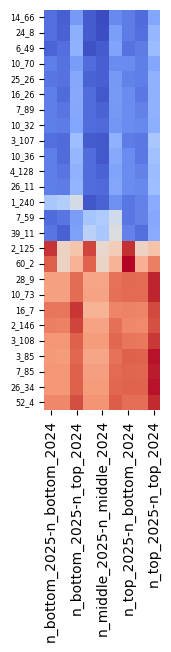

In [225]:
def pivot_differential_expression(diff_df, column_order=['n_bottom_2025', 'n_middle_2025', 'n_top_2025']):
    diff_df['sample_pair_name'] = [f'{row.sample_name}-{row.control_sample_name}' for row in diff_df.itertuples()]
    diff_df = diff_df.pivot(columns='sample_pair_name', values='delta', index='gene_id').copy()
    # diff_df = diff_df[column_order].copy()
    return diff_df

def plot_differential_expression(diff_df:pd.DataFrame, annotations:dict=None, ids=None):
    figure_df = diff_df.copy()

    figure_df = figure_df[figure_df['gene_id'].isin(ids)].copy() if (ids is not None) else figure_df
    figure_df = pivot_differential_expression(figure_df)

    ids = figure_df.index.copy()
    if annotations is not None:
        figure_df.index = figure_df.index.map(annotations)
        figure_df.index = np.where(figure_df.index.isnull(), ids, figure_df.index)

    figure_df['mean'] = figure_df.values.mean(axis=1).ravel()
    figure_df = figure_df.sort_values(by='mean') # Sort by the average delta across all samples.. 

    fig, ax = plt.subplots(figsize=(1.5, len(figure_df) / 5))
    sns.heatmap(figure_df.drop(columns='mean'), cmap='coolwarm', cbar=False, ax=ax)
    ax.set_yticks(np.arange(len(figure_df)) + 0.5, figure_df.index.values, fontsize='xx-small')
    # ax.set_xticks(ax.get_xticks(), labels=['bottom', 'middle', 'top'], fontsize='xx-small')
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax , ids
    # plt.show()

annotations = ko_df.set_index('id')['definition'].to_dict()
# annotations.update(mp_diff_df[~host_df['product'].str.contains('hypothetical|Tax=')]['product'].to_dict())
# annotations['7_12'] = 'Domain of unknown function DUF3303' # Several members are annotated as being LysM domain-like proteins, but these did not match any LysM domains reported in the literature. 
# annotations['22_21'] = 'NADH oxidase'
# annotations['12_41'] = 'Integrin alpha N-terminal domain'
# annotations['52_1'] = 'Multiheme cytochromes'
# annotations['52_4'] = 'Multiheme cytochromes'

ax, ids = plot_differential_expression(mp_diff_df[mp_diff_df.consistent], ids=important_gene_ids)
# ax = plot_differential_expression(host_diff_df[~host_diff_df.consistent], annotations=annotations, ids=important_ids)
plt.show()
# It seems likely that a lot of what PCA is capturing is the variance between locations, not between samples. 
# Values are the value in the treatment group (nitrate) minus the value in the control (no nitrate)

In [210]:
# mp_diff_df[mp_diff_df.consistent].pivot(columns='sample_name', values='delta', index='gene_id')
mp_diff_df[mp_diff_df.consistent].sample_name.value_counts()

sample_name
n_bottom_2025    369
n_middle_2025    369
n_top_2025       369
Name: count, dtype: int64

In [ ]:
# host_interpro_df = InterProScanFileTSV.from_file(f'../data/interproscan/methanoperedens_2.tsv').to_df()
# host_interpro_df = host_interpro_df.sort_values(['id', 'e_value'])
# host_interpro_df[host_interpro_df['id'].isin(['7_12', '12_41', '49_6', '26_29', '22_21', '52_1', '52_4'])]
# host_interpro_df[host_interpro_df['id'].isin(ids)].sort_values('e_value').drop_duplicates('id')
# len(ids), len(host_interpro_df[host_interpro_df['id'].isin(ids)])

# pathways = dict()
# pathways['map00680'] = 'methane metabolism'
# pathways['map01310'] = 'nitrogen cycle  '
# pathways['map00910'] = 'nitrogen metabolism'

# def load_kos(pathway, kegg_dir='../data/kegg'):
#     path = os.path.join(kegg_dir, f'{pathway}.tsv')
#     df = pd.read_csv(path, sep='\t', names=['id', 'ko'])
#     kos =  df.ko.values.tolist()
#     kos = [ko.split(':')[-1] for ko in kos]
#     return kos

# map00910_kos = load_kos('map00910')
# map00680_kos = load_kos('map00680')

# print('Num. genes with a KO group:', ko_df['id'].nunique(), 'out of', mp_metat_df['id'].nunique())
# print('Num. KO groups:', ko_df['ko'].nunique())

In [ ]:
def get_overlaps(id_:str, remove_ids:list=[f'1_{i}' for i in range(39, 67)]):
    cols = ['contig_id', 'model', 'feature_type', 'start', 'stop', 'score', 'strand', 'phase', 'id']
    kwargs = {'sep':'\t', 'comment':'#', 'names':cols}
    ece_df = pd.concat([pd.read_csv(f'../data/{ece_id}.gff', **kwargs), pd.read_csv(f'../data/{ece_id}_all_orfs.gff', **kwargs)])

    ece_df = ece_df[~ece_df.index.duplicated()].copy()
    ece_df = ece_df[~ece_df.index.isin(remove_ids)].copy()
    ece_df['id'] = ece_df['id'].str.replace('ID=', '')
    ece_df = ece_df.set_index('id')

    start, stop = ece_df.loc[id_].start, ece_df.loc[id_].stop 
    df = ece_df[~((ece_df.start >= stop) | (ece_df.stop <= start))].copy()
    df = df[df.index != id_].copy()
    return df.index.tolist()

In [ ]:

ece_metat_df = metat_df[metat_df.target_name.isin([ece_id])].copy() # Should include the weird ones on the opposite strand. 
ece_metat_df = ece_metat_df.drop_duplicates(['sample_name', 'gene_id'])
ece_metat_df = get_clr_normalization(ece_metat_df)
ece_diff_df = get_differential_expression(ece_metat_df)

ax, _ = plot_differential_expression(ece_diff_df)
plt.show()

# ko_df = kegg_load('../data/kegg/methanoperedens_2.txt')
# ko_df['target_name'] = 'methanoperedens_2'
# # ko_df['id'] = [f'{target_name}_{gene_id}' for target_name, gene_id in zip(ko_df.target_name, ko_df['id'])]
# ko_df = ko_df.sort_values('e_value').drop_duplicates('id')

# host_df = GenBankFile.from_file('../data/methanoperedens_2.gbk').to_df()
# # host_df['ko']
# host_df['ko'] = host_df.index.map(ko_df.set_index('id').ko.to_dict())
# host_df['ko_definition'] = host_df.index.map(ko_df.set_index('id').definition.to_dict())
# host_df[['ko', 'ko_definition']] = host_df[['ko', 'ko_definition']].fillna('none')

AttributeError: 'DataFrame' object has no attribute 'control_sample_name'

In [ ]:
def get_correlation(gene_id_1:str, gene_id_2:str, metat_df):
    read_length = 150
    gene_length_1  = metat_df[metat_df.gene_id == gene_id_1].length.values[0]
    gene_length_2 = metat_df[metat_df.gene_id == gene_id_2].length.values[0]

    df = metat_df[metat_df.gene_id.isin([gene_id_1, gene_id_2])].copy()
    df = df.pivot(values='read_count_original', index='sample_name', columns='gene_id')
    df += 1 # Add a pseudocount of 1
    df[gene_id_1] = np.log(df[gene_id_1] * read_length / gene_length_1)
    df[gene_id_2] = np.log(df[gene_id_2] * read_length / gene_length_2)

    x, y = df[gene_id_1].values, df[gene_id_2].values 
    result = pearsonr(x, y)
    return {'gene_id_1':gene_id_1, 'gene_id_2':gene_id_2, 'r':result.statistic, 'r_squared':result.statistic ** 2, 'p_value':result.pvalue}


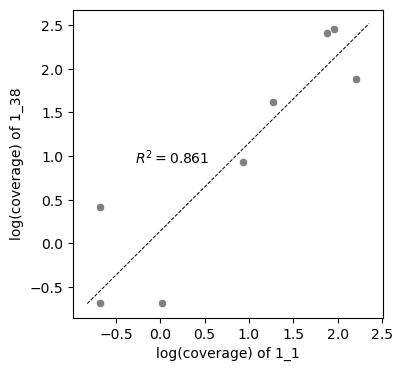

In [ ]:
def plot_correlation(gene_id_1:str, gene_id_2:str, metat_df):
    fig, ax = plt.subplots(figsize=(4, 4))

    read_length = 150
    gene_length_1  = metat_df[metat_df.gene_id == gene_id_1].length.values[0]
    gene_length_2 = metat_df[metat_df.gene_id == gene_id_2].length.values[0]

    figure_df = metat_df[metat_df.gene_id.isin([gene_id_1, gene_id_2])].copy()
    figure_df = figure_df.pivot(values='read_count_original', index='sample_name', columns='gene_id')
    figure_df += 1 # Add a pseudocount of 1
    figure_df[gene_id_1] = np.log(figure_df[gene_id_1] * read_length / gene_length_1)
    figure_df[gene_id_2] = np.log(figure_df[gene_id_2] * read_length / gene_length_2)

    sns.scatterplot(figure_df, x=gene_id_1, y=gene_id_2, color='gray')

    x, y = figure_df[gene_id_1].values, figure_df[gene_id_2].values 
    r = np.corrcoef(x, y)[0, 1]
    m, b = np.polyfit(x, y, 1)

    x_min, x_max = ax.get_xlim()
    sns.lineplot(x=np.linspace(x_min, x_max, 10), y=np.linspace(x_min, x_max, 10) * m + b, ls='--', color='black', lw=0.7)
    ax.text(0.2, 0.5, f'$R^2=$' + f'{r ** 2:.3f}', transform=ax.transAxes)
    ax.set_xlabel(f'log(coverage) of {gene_id_1}')
    ax.set_ylabel(f'log(coverage) of {gene_id_2}')

    plt.show()

plot_correlation('1_1', '1_38', ece_metat_df)


In [ ]:
# Look for genes which are co-regulated across samples. Because we are comparing within samples, don't need to normalize by library size. 
# Just compare coverages. 

# Note that this test is assuming samples are independent, but possible that the samples from the same bioreactors are correlated. 

gene_id_pairs = list(itertools.combinations(ece_metat_df.gene_id.unique(), 2))
ece_metat_df = ece_metat_df.sort_values('sample_name')

figure_df = list()
for gene_id_1, gene_id_2 in gene_id_pairs:
    figure_df.append(get_correlation(gene_id_1, gene_id_2, ece_metat_df))
figure_df = pd.DataFrame(figure_df)

p_values = figure_df['p_value'].values
reject, p_values_adjusted, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh') # Benjamini-Hochberg FDR correction. 
figure_df['p_value_adjusted'] = p_values_adjusted
figure_df['reject'] = reject

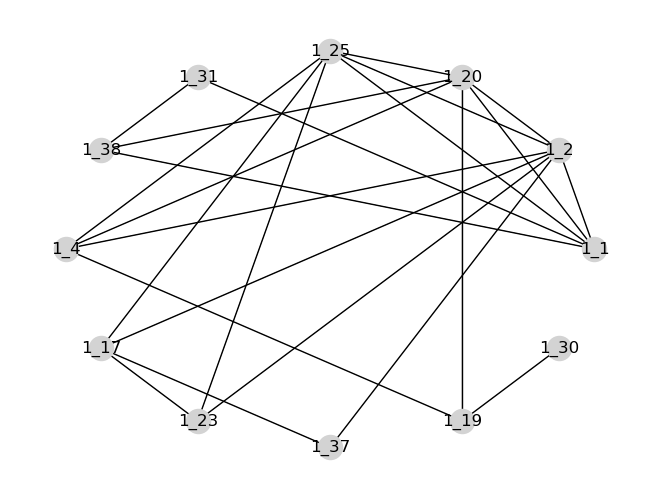

In [ ]:

graph = nx.Graph()
for row in figure_df[figure_df.p_value_adjusted < 0.02].itertuples():
    graph.add_node(row.gene_id_1)
    graph.add_node(row.gene_id_2)
    graph.add_edge(row.gene_id_1, row.gene_id_2, weight=np.log10(1 / row.p_value) / 100)
# pos=nx.spring_layout(graph, weight='weight')
pos = nx.circular_layout(graph)

nx.draw(graph, with_labels=True, pos=pos, node_color='lightgray')

edge_widths = [d['weight'] * 5 for (u, v, d) in graph.edges(data=True)]
nx.draw_networkx_edges(graph, pos=pos, width=edge_widths)


In [ ]:
# fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(12, 4), width_ratios=[0.75, 0.25])

# print('Num. ECE genes which are expressed:', ece_metat_df[~ece_metat_df.reversed].gene_id.nunique())
# print('Num. ECE genes which are expressed on the opposite strand:', ece_metat_df[ece_metat_df.reversed].gene_id.nunique())
# ids = np.intersect1d(ece_metat_df[ece_metat_df.reversed].gene_id.unique(), ece_metat_df[~ece_metat_df.reversed].gene_id.unique())
# print('Num. ECE genes which are expressed on the both strands:', len(ids))

# figure_df = ece_metat_df.copy()
# figure_df = figure_df[figure_df.sample_name.str.contains('2025')].copy()
# figure_df['nitrate'] = figure_df.sample_name.str.startswith('n')
# get_sample_location = lambda sample_name : re.search('top|bottom|middle', sample_name).group(0)
# figure_df['location'] = figure_df.sample_name.apply(get_sample_location)


# transcription_factor_ids = ['1_1', '1_12', '1_17', '1_32', '1_38']

# ax_df = figure_df[~figure_df.reversed].copy()
# ax_df = get_clr_normalization(ax_df)
# ax_df = ax_df[ax_df.gene_id.isin(transcription_factor_ids)].copy()
# ax_a.axhline(0, color='black', ls='--')
# # sns.boxplot(ax_df, x='gene_id', y='normalized_coverage', ax=ax_a, color='lightgray', showfliers=False)
# sns.boxplot(ax_df, x='gene_id', y='normalized_coverage', ax=ax_a, palette='Grays', hue='location', showfliers=False)
# # sns.stripplot(ax_df, x='gene_id', y='normalized_coverage', ax=ax_a, color='gray', s=3)


# # ax_df = ax_df[]
# ax_df = get_clr_normalization(figure_df)
# ax_df['reversed'] = np.where(ax_df.reversed, 'opposite_strand', 'original_strand')
# ax_df['id'] = [f'{row.sample_name}_{row.gene_id}' for row in ax_df.itertuples()]
# remove_ids = ax_df.groupby('id').apply(lambda df : np.all(df.read_count_original == 0), include_groups=False)
# remove_ids = remove_ids[remove_ids].index.values

# ax_df = ax_df[~ax_df['id'].isin(remove_ids)]
# ax_df = ax_df.pivot(columns='reversed', index=['gene_id', 'sample_name'], values='normalized_coverage')
# ax_df = ax_df.reset_index(drop=False)

# # ids = ['1_2', '1_17', '1_19', '1_23', '1_30', '1_31', '1_37', '1_38']
# sns.scatterplot(ax_df, x='original_strand', y='opposite_strand', hue='gene_id', legend=False, palette='Grays')
# # ax_b.set_yscale('log')
# # ax_b.set_xscale('log')
# fig.tight_layout()
# plt.show()

# # Using the normalized coverage could be problematic due to the fact that an overall decrease in the expression of ECE genes could look like
# # an increase in the expression of a particular gene, so need to be careful about what we can say from this. 

In [ ]:

# # Want to see which genes the expression profiles most correlate with, perhaps. Best way to do this might be PCA, though there are
# # only three features, so might be iffy. Probably better to just do correlation directly. 
# def get_correlated_expressions(ece_diff_df:pd.DataFrame, host_diff_df:pd.DataFrame):
#     ece_diff_df = pivot_differential_expression(ece_diff_df)
#     host_diff_df = pivot_differential_expression(host_diff_df)

#     corr_df = pd.DataFrame(index=ece_diff_df.index, columns=host_diff_df.index)
#     for ece_values in ece_diff_df.itertuples():
#         for host_values in host_diff_df.itertuples():
#             # r = np.corrcoef(ece_values[1:], host_values[1:])[0][1]
#             r = pearsonr()
#             corr_df.loc[ece_values[0], host_values[0]] = r ** 2
#     return corr_df

# corr_df = get_correlated_expressions(ece_diff_df, host_diff_df)

In [ ]:
# corr_expression = dict()
# threshold = 0.95

# fig, ax = plt.subplots(figsize=(4, 4))
# for row in corr_df.itertuples():
#     values = np.array(list(row[1:]))
#     corr_expression[row[0]] =  corr_df.columns.to_numpy()[values > threshold].tolist()
#     sns.kdeplot(values, color='gray', alpha=0.5, ax=ax)

# ax.set_ylabel('density')
# ax.set_xlim(xmin=0, xmax=1)
# ax.axvline(threshold, lw=0.7, color='black', ls='--')
# plt.show()

In [ ]:
# # Characterize patterns across samples with Kolmogorov-Smirnov test. If one-sided, it will q
# fig, ax = plt.subplots(figsize=(4, 3))

# # We are testing to see if the ECE transciption is greater than the host, with the null being that it is less than the host. 
# # For alternative='greater': The null hypothesis is that F(x) <= G(x) for all x; the alternative is that F(x) > G(x) for at least one x.

# alternative = 'two-sided'
# alternative = 'less'
# get_ks_result = lambda df : scipy.stats.kstest(df[~df.host].normalized_coverage.values, df[df.host].normalized_coverage.values, alternative=alternative)

# ax_df = pd.DataFrame(index=pd.Series(figure_df.sample_name.unique(), name='sample_name'))
# ax_df['p_value'] = figure_df.groupby('sample_name').apply(lambda df : get_ks_result(df).pvalue, include_groups=False)
# ax_df['statistic'] = figure_df.groupby('sample_name').apply(lambda df : get_ks_result(df).statistic, include_groups=False)
# signficant_samples = ax_df.index[ax_df.p_value < 0.05].values

# ax_df = ax_df.sort_values('sample_name')
# sns.barplot(ax_df, x='sample_name', y='statistic', hue='p_value', palette='Grays', edgecolor='black')
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

# for x, label in zip(ax.get_xticks(), ax.get_xticklabels()):
#     if label.get_text() in signficant_samples:
#         ax.text(x, ax.get_ylim()[-1], '*', ha='center', va='top', fontsize=14)

# ax.set_xlabel('')
# ax.get_legend().set_title('p-value')
# ax.set_title(f'alternative="{alternative}"')
# plt.show()

# for row in ax_df.itertuples():
#     print(f'Sample {row.Index}, p-value {row.p_value}')

# # There are a couple of explanations for the patterns here. Firstly, it could be that the relative copy number of host to ECE changes, 
# # in which case the changes in transcription could be caused by an increase in the number of ECE per cell (plausible considering the plot above, 
# # also unclear if there are potentially other hosts in the environment). Or, more interestingly, the Methanoperedens which are able to survive in 
# # the low-nitrate conditions preferentially have the ECE. 

# # Another possible reason is that the general level of host activity has decreased, resulting in a higher CLR mean. However, 
# # this would imply that the transcriptional activity of the ECE has changed by less. 

# # To me, because ECE genes are likely transcribed by host transcription machinery, it seems most likely that ECE genes would be specifically 
# # up-regulated. I would expect a general decrease in host transcriptional activity to coincide with a decrease in ECE activity as well, 
# # simply because the same proteins are being used. Not sure if there is any precedence for a systemic decrease in host transcription resulting in 
# # a relative increase in host transcription. 

In [ ]:
# df = mp_metat_df.pivot(columns='sample_name', values='normalized_coverage', index='id').copy()
# # df.columns = df.columns.get_level_values(1)
# df = df.reset_index()

# n_sample_names = mp_metat_df.sample_name[mp_metat_df.sample_name.str.startswith('n_')].unique()
# ck_sample_names = mp_metat_df.sample_name[~mp_metat_df.sample_name.str.startswith('n_')].unique()

# diff_df = list()
# for n_sample_name, ck_sample_name in itertools.product(n_sample_names, ck_sample_names):
#     # diff_df += [{'id':row['id'], 'diff':row[n_sample_name] - row[ck_sample_name], 'ck_sample_name':ck_sample_name, 'n_sample_name':n_sample_name} for row in df.to_dict(orient='records')]
# diff_df = pd.DataFrame(diff_df)

# # Perhaps shouldn't trust the genes with a high degree of variance in their differential expression. 

# # ChaTGPT suggested using median absolute deviation instead, which is more robust to outliers. 
# # Could take two approaches: remove outlier samples, or just remove entire genes. 

# # MAD score on its own does not capture directional consistency, which is resulting in poor filtering. 
# # Also want to make sure that the majority of samples have the same sign, i.e. a gene is either up- or down- regulated, not both. 
# is_consistently_regulated = lambda df : np.all(np.sign(df['diff'].values) == np.sign(df['diff'].values)[0])
# threshold = 0.7
# is_consistently_regulated = lambda df : (np.sign(df['diff'].values) == np.sign(df['diff'].values)[0]).mean() > threshold
                                       
# # First compute the mean absolute deviation for a given sample, which is essentially the median of the difference between the values and the median. 
# diff_df['sample_median'] = diff_df['id'].map(diff_df.groupby('id')['diff'].median())
# diff_df['consistently_regulated'] = diff_df['id'].map(diff_df.groupby('id').apply(is_consistently_regulated, include_groups=False))
# diff_df['diff_minus_sample_median'] = np.abs(diff_df['diff'] - diff_df.sample_median)
# diff_df['median_absolute_deviation'] = diff_df['id'].map(diff_df.groupby('id').diff_minus_sample_median.median())
# diff_df['median_absolute_deviation_z_score'] = diff_df.diff_minus_sample_median / diff_df.median_absolute_deviation
# diff_df['std'] = diff_df['id'].map(diff_df.groupby('id')['diff'].std())

# threshold = 3
# # print('Num. genes with the standard deviation exceeding the threshold:', diff_df[(diff_df['std'] > threshold)]['id'].nunique())
# print('Num. total genes:', diff_df['id'].nunique())
# print('Num. values with the MAD score exceeding the threshold:', (diff_df.median_absolute_deviation_z_score > threshold).sum())
# print('Num. genes with the MAD score exceeding the threshold in at least one sample:', diff_df[diff_df.median_absolute_deviation_z_score > threshold]['id'].nunique())

# variable_ids = diff_df[(diff_df.median_absolute_deviation_z_score > threshold)]['id'].unique().tolist()
# variable_ids += diff_df[~diff_df.consistently_regulated]['id'].unique().tolist()

# mask = ~diff_df['id'].isin(variable_ids)
# print('Num. samples removed:', (~mask).sum(), 'out of', len(diff_df))
# # diff_df = diff_df[diff_df.median_absolute_deviation_z_score <= threshold].copy()
# diff_df = diff_df[mask].copy()

In [ ]:
# fig, ax = plt.subplots(figsize=(4, 4))

# upregulated_threshold = 3
# downregulated_threshold = -3

# diff_df['upregulated'] = diff_df['diff'] > upregulated_threshold
# diff_df['downregulated'] = diff_df['diff'] < downregulated_threshold
# diff_df['ko'] = diff_df['id'].map(kegg_df.sort_values('e_value').drop_duplicates('id').set_index('id').ko)
# diff_df['module'] = diff_df.ko.map({ko:map_[0] for ko, map_ in ko_to_module_map.items()}) # Just get the first module for now. 
# diff_df['module_description'] = diff_df.module.map(module_name_map)
# diff_df['ko_description'] = diff_df.ko.map(ko_name_map)
# diff_df['regulation'] = np.select([diff_df.upregulated, diff_df.downregulated], ['+', '-'], default='.')
# diff_df = diff_df.fillna('none')

# upregulated_ids = diff_df[diff_df.upregulated]['id'].unique()
# downregulated_ids = diff_df[diff_df.downregulated]['id'].unique()
# assert len(np.intersect1d(upregulated_ids, downregulated_ids)), 'There are genes marked as both significantly up- and down- regulated.'

# print('Num. genes upregulated:', len(upregulated_ids))
# print('Num. genes downregulated:', len(downregulated_ids))

# sns.kdeplot(diff_df, x='diff', color='gray')
# ax.set_ylabel('density')
# plt.show()

In [ ]:
# # Some Kegg Ortho groups are not associated with pathways. 
# upregulated_pathways = [pathway for ko in diff_df[diff_df.upregulated].ko.dropna().unique() if (ko in ko_to_pathway_map) for pathway in ko_to_pathway_map[ko]]
# downregulated_pathways = [pathway for ko in diff_df[diff_df.downregulated].ko.dropna().unique() if (ko in ko_to_pathway_map) for pathway in ko_to_pathway_map[ko]]

# # upregulated_modules = [mod for ko in diff_df[diff_df.upregulated].ko.dropna().unique() if (ko in ko_to_module_map) for mod in ko_to_module_map[ko]]
# # downregulated_modules = [mod for ko in diff_df[diff_df.downregulated].ko.dropna().unique() if (ko in ko_to_module_map) for mod in ko_to_module_map[ko]]
# upregulated_modules = [ko_to_module_map[ko][0] for ko in diff_df[diff_df.upregulated].ko.dropna().unique() if (ko in ko_to_module_map)]
# downregulated_modules = [ko_to_module_map[ko][0] for ko in diff_df[diff_df.downregulated].ko.dropna().unique() if (ko in ko_to_module_map)]

# min_count = 1
# figure_df = [{'module':mod, 'category':'upregulated'} for mod in upregulated_modules]
# figure_df += [{'module':mod, 'category':'downregulated'} for mod in downregulated_modules]
# figure_df = pd.DataFrame(figure_df)
# # figure_df = figure_df[figure_df.module.str.startswith('map')].copy()
# figure_df = figure_df[figure_df.module.str.startswith('M')].copy()
# figure_df['count'] = figure_df.module.map(figure_df.module.value_counts())
# figure_df = figure_df[figure_df['count'] > min_count].copy()

# fig, ax = plt.subplots(figsize=(10, 4))
 
# sns.histplot(figure_df, x='module', hue='category', multiple='dodge', palette='Grays')
# labels = [module_name_map[module.get_text()] for module in ax.get_xticklabels()]
# labels = [label.split(',')[0] for label in labels]
# ax.set_xticks(ax.get_xticks(), labels, rotation=90)
# ax.set_xlabel('')
# ax.get_legend().set_title('')
# plt.show()

In [ ]:
# # First want to compare the Methanoperedens read counts and ECE read counts across samples. 

# figure_df = list()

# for sample_name, df in metat_df.groupby('sample_name'):
#     for i in range(1, 3):
#         row = {'methanoperedens_id':i, 'sample_name':sample_name}
#         row['Methanoperedens'] = df[df.target_name == f'methanoperedens_{i}'].coverage.mean()
#         row['ECE'] = df[df.target_name == ece_id].coverage.mean()
#         figure_df.append(row)
# figure_df = figure_df[figure_df.methanoperedens_id == 2].copy() # values for 2 are consistently higher, maybe the genome is more complete. 
# figure_df = pd.DataFrame(figure_df)
# # figure_df = figure_df[figure_df.sample_name.str.startswith('n')].copy() # Nitrate samples only, for now. 
# # figure_df['sample_location'] = [re.search('top')]

# sns.scatterplot(figure_df, x='ECE', y='Methanoperedens', legend=True, hue='methanoperedens_id')
# # sns.scatterplot(figure_df, x='ECE', y='Methanoperedens', hue='methanoperedens_id', legend=False, palette={1:'gray', 2:'darkgray'})


In [ ]:
# figure_df = metat_df.copy()
# figure_df['category'] = np.where(metat_df.target_name.str.contains('methanoperedens'), 'host', 'ECE')

# for sample_name, df in figure_df.groupby('sample_name'):
#     print(f'Percentage of genes with no mapped reads in sample {sample_name}: {100 * (df.coverage == 0).sum() / len(df):.2f}%')
# # figure_df = figure_df[figure_df.coverage > 0].copy()

# fig, axes = plt.subplots()
# sns.ecdfplot(figure_df, x='coverage', hue='sample_name', palette='Grays')
# ax.set_xlim(xmin=0, xmax=5)

# # How to go about normalizing this? Differences in ECE and Methanoperedens read counts might be related to differing numbers of each group 
# # in the sample

In [ ]:
# This is just a more complicated and difficult-to-explain version of the analysis above. 

# # Despite being about 10 times more abundant than the host genome in the samples, the transcript activity on the ECE is similar to that of 
# # most of the host genes. Not completely sure how to rationalize this. Perhaps implies that there is a lot that's not actually associated with a cell?

# figure_df = metat_df.copy()
# figure_df = figure_df[figure_df.target_name.isin([ece_id, 'methanoperedens_2'])].copy() # More reads map to the second genome, and I think it is more complete. 
# figure_df['host'] = figure_df.target_name != ece_id

# # I need to normalize the data somehow to facilitate comparison across samples. Using the Methanoperedens transcript data from each sample as a way
# # to normalize, which involves using the assumption that Methanoperedens versus ECE abundance is relatively fixed across samples. 
# clr_mean = {sample_name:np.log(scipy.stats.gmean(df[df.host].coverage)) for sample_name, df in figure_df.groupby('sample_name')}
# figure_df['clr_mean'] = figure_df.sample_name.map(clr_mean)
# figure_df['normalized_coverage'] = np.log(figure_df.coverage) - figure_df.clr_mean

# def plot_coverage_ecdf(figure_df, ax=plt.Axes, year='2025', nutrients='ck_'):
#     sample_names = [sample_name for sample_name in figure_df.sample_name.unique() if year in sample_name]
#     sample_names = [sample_name for sample_name in sample_names if nutrients in sample_name]
#     figure_df['sample'] = figure_df['sample_name']

#     sns.ecdfplot(figure_df[(figure_df.host) & (figure_df.sample_name.isin(sample_names))], x='normalized_coverage', color='lightgray', hue='sample', ls=':', palette='Grays', ax=ax)
#     sns.ecdfplot(figure_df[(~figure_df.host) & (figure_df.sample_name.isin(sample_names))], x='normalized_coverage', hue='sample', palette='Grays', ax=ax)
#     # ax.set_xlim(xmin=-1, xmax=3)
#     # ax.set_ylim(ymin=0)
#     # ax.get_legend().set_title('')
#     ax.set_ylabel('proportion')
#     ax.set_xlabel('normalized coverage (CLR)')

# fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

# plot_coverage_ecdf(figure_df, ax=axes[0], nutrients='ck_')
# plot_coverage_ecdf(figure_df, ax=axes[1], nutrients='n_')

# fig.tight_layout()
# plt.show()


In [ ]:
# # And the absolute regulation of the ECE genes in each condition, as well as transcription from the reverse strand.  
# metat_df = metat_load()
# metat_df['id'] = [f'{target_name}_{gene_id}' for target_name, gene_id in zip(metat_df.target_name, metat_df.gene_id)]
# metat_df = filter_low_counts(metat_df, min_count=3)

# ece_metat_df = metat_df[metat_df.target_name.isin([ece_id, f'{ece_id}_rev'])].copy() # Should include the weird ones on the opposite strand. 
# ece_metat_df = ece_metat_df.drop_duplicates(['target_name', 'sample_name', 'gene_id'])
# # ece_metat_df = get_clr_normalization(ece_metat_df)
# ece_metat_df['reversed'] = ece_metat_df.target_name.str.contains('rev')